# Librerias

In [1]:
import monai
import numpy as np
import os
import pickle

# Exploración incial

## Instancias sin label

In [2]:
images_base_path = "../../../data/images/"
labels_base_path = "../../../data/labels/csPCa_lesion_delineations/human_expert/original/"

patient_folders = [f for f in os.listdir(images_base_path) if os.path.isdir(os.path.join(images_base_path, f))]

images_without_labels = []
images_with_labels = []

for patient_id in patient_folders:
    patient_path = os.path.join(images_base_path, patient_id)
    
    files_in_folder = os.listdir(patient_path)
    
    study_groups = {}
    for file_name in files_in_folder:
        if "_" in file_name:
            base_name = file_name.split("_")
            study_id = base_name[1] 
            
            if study_id not in study_groups:
                study_groups[study_id] = []
            study_groups[study_id].append(file_name)
    
    for study_id, study_files in study_groups.items():
        label_path = os.path.join(labels_base_path, f"{patient_id}_{study_id}.nii.gz")
        label_exists = os.path.exists(label_path)

        if not label_exists:
            images_without_labels.append({
                'patient_id': patient_id,
                'study_id': study_id,
            })
        else:
            images_with_labels.append({
                'patient_id': patient_id,
                'study_id': study_id,
            })

In [3]:
print(f"Total patients --> {len(patient_folders)}")
print(f"Images with label --> {len(images_with_labels)}")
print(f"Images without label --> {len(images_without_labels)}")
print(f"Total images --> {len(images_with_labels) + len(images_without_labels)}")

Total patients --> 1476
Images with label --> 1295
Images without label --> 205
Total images --> 1500


## Pacientes con más de un estudio

In [4]:
from collections import Counter

patient_ids = [entry['patient_id'] for entry in images_with_labels]
patient_counts = Counter(patient_ids)

patients_with_multiple_studies = {patient_id: count for patient_id, count in patient_counts.items() if count > 1}
patients_with_multiple_studies

{'10129': 2,
 '10131': 2,
 '10153': 2,
 '10193': 2,
 '10281': 2,
 '10404': 2,
 '10417': 2,
 '10490': 2,
 '10512': 2,
 '10540': 2,
 '10548': 2,
 '10576': 2,
 '10580': 2,
 '10629': 2,
 '10634': 2,
 '10905': 2,
 '10936': 3,
 '11004': 2,
 '11059': 2,
 '11087': 2,
 '11383': 2}

# Análisis exploratorio

In [5]:
img_columns = ['t2','dwi','adc', 'label']

transforms = monai.transforms.Compose([
                monai.transforms.LoadImaged(keys=img_columns, image_only=False, ensure_channel_first = True),
                monai.transforms.ResampleToMatchd(
                    keys=["adc", "dwi"],
                    key_dst="t2",
                    mode=("bilinear", "bilinear"),
                ),
                monai.transforms.ScaleIntensityd(keys=['t2','dwi','adc'], minv=0.0, maxv=1.0, allow_missing_keys=True),
                monai.transforms.ConcatItemsd(keys=['t2','dwi','adc'], name="image", dim=0)
                ])

In [6]:
def get_study_and_patient(patient_id, data = images_with_labels):
    for record in data:
        if record['patient_id'] == str(patient_id):
            return record['patient_id'], record['study_id']
    return None

In [7]:
patient_id, study_id = get_study_and_patient('11002')

image_dict = {
    't2': f"../../../data/images/{patient_id}/{patient_id}_{study_id}_t2w.mha",
    'dwi': f"../../../data/images/{patient_id}/{patient_id}_{study_id}_hbv.mha",
    'adc': f"../../../data/images/{patient_id}/{patient_id}_{study_id}_adc.mha",
    'label': f"../../../data/labels/csPCa_lesion_delineations/human_expert/original/{patient_id}_{study_id}.nii.gz"
}

processed_image = transforms(image_dict)

In [8]:
processed_image['label'].unique()

metatensor([0., 5.])

In [9]:
blended = monai.visualize.utils.blend_images(processed_image['t2'],
                                            processed_image["label"],
                                            alpha=0.5,
                                            transparent_background=True)

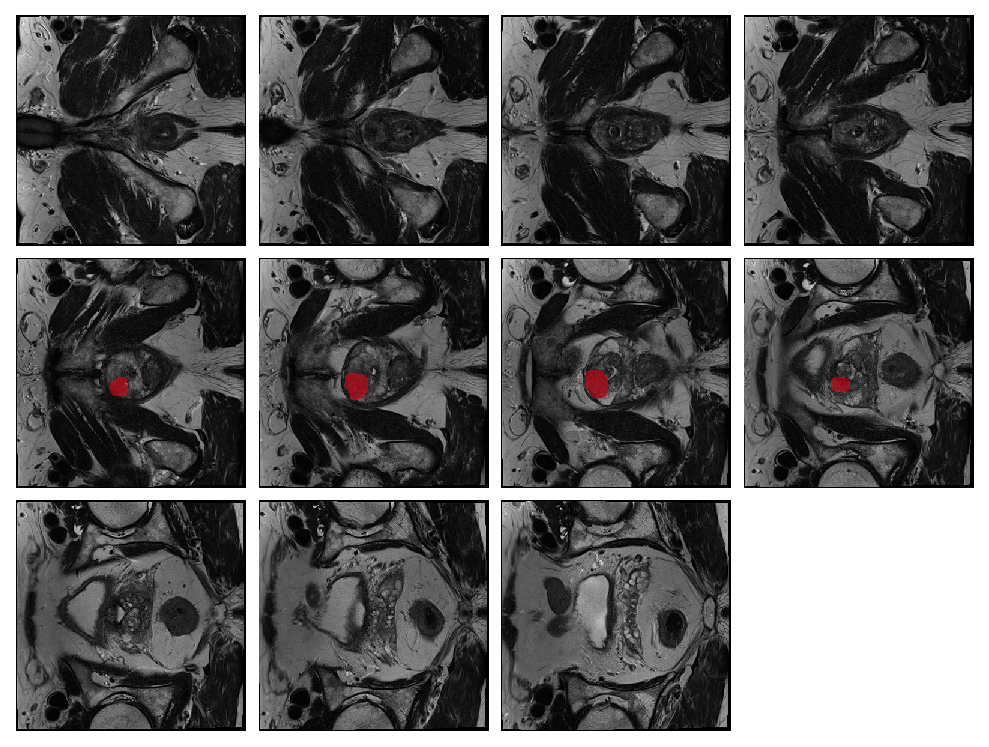

(<Figure size 1000x1000 with 1 Axes>,
 array([[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],
 
        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],
 
        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],
 
        ...,
 
        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],
 
        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],
 
        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
    

In [10]:
monai.visualize.matshow3d(volume=blended, frame_dim=-1, channel_dim=0, every_n=2, margin=10, show=True)